In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import pyro
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau
from sklearn.model_selection import train_test_split
from cometml_api import api
from bb_opt.src.bayesian_opt import (
    normal_priors, normal_variationals,
    spike_slab_priors, SpikeSlabNormal,
    make_bnn_model, make_guide,
    train, bnn_predict, optimize,
    get_model_bnn, acquire_batch_bnn_greedy, train_model_bnn,
    get_model_nn, acquire_batch_nn_greedy, train_model_nn
)


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 100

%matplotlib inline

In [2]:
def jointplot(predicted, true, title: str=""):
    if isinstance(predicted, torch.Tensor):
        predicted = predicted.detach().cpu().numpy()

    if isinstance(true, torch.Tensor):
        true = true.detach().cpu().numpy()
        
    ax = sns.jointplot(predicted, true, s=3, alpha=0.5)
    ax.set_axis_labels('Predicted', 'True')
    ax.ax_marg_x.set_title(title)
    return ax

# Predictive Performance

In [3]:
inputs = np.load("../data/dna_binding/crx_ref_r1/inputs.npy")
labels = np.load("../data/dna_binding/crx_ref_r1/labels.npy")
inputs.shape, labels.shape

((32896, 32), (32896,))

In [6]:
n_hidden = 100
non_linearity = 'ReLU'
n_inputs = inputs.shape[1]

model = nn.Sequential(
    nn.Linear(n_inputs, n_hidden),
    getattr(nn, non_linearity)(),
    nn.Linear(n_hidden, 1)
).to(device)

## Deterministic NN

In [112]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, test_size=.5)

train_inputs = torch.tensor(train_inputs).float().to(device)
train_labels = torch.tensor(train_labels).float().to(device)
train_data = TensorDataset(train_inputs, train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_inputs = torch.tensor(test_inputs).float().to(device)
test_labels = torch.tensor(test_labels).float().to(device)

In [114]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()

In [115]:
losses = []

for epoch in range(300):
    model.train()
    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        predictions = model(inputs).squeeze()
        loss = loss_func(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        predictions = model(test_inputs).squeeze()
        test_loss = loss_func(predictions, test_labels)

    if epoch % 5 == 0:
        print(f'[E{epoch}] Loss = {loss.item():.3f}. Val loss = {test_loss.item():.3f}')

[E0] Loss = 7321120768.000. Val loss = 7777539072.000
[E5] Loss = 329797664.000. Val loss = 461129792.000
[E10] Loss = 629759616.000. Val loss = 305453664.000
[E15] Loss = 123909480.000. Val loss = 258725040.000
[E20] Loss = 102381992.000. Val loss = 243180112.000
[E25] Loss = 82809544.000. Val loss = 240958752.000
[E30] Loss = 127107704.000. Val loss = 240846688.000
[E35] Loss = 343243712.000. Val loss = 240966912.000
[E40] Loss = 142281840.000. Val loss = 240846608.000
[E45] Loss = 223131920.000. Val loss = 240888768.000
[E50] Loss = 184411440.000. Val loss = 240927232.000
[E55] Loss = 165409936.000. Val loss = 241024160.000
[E60] Loss = 306267552.000. Val loss = 241099200.000
[E65] Loss = 352547168.000. Val loss = 240850288.000
[E70] Loss = 118887320.000. Val loss = 241057952.000
[E75] Loss = 166725872.000. Val loss = 240878224.000
[E80] Loss = 74236312.000. Val loss = 240923696.000
[E85] Loss = 120328704.000. Val loss = 240824224.000
[E90] Loss = 130440232.000. Val loss = 240866864

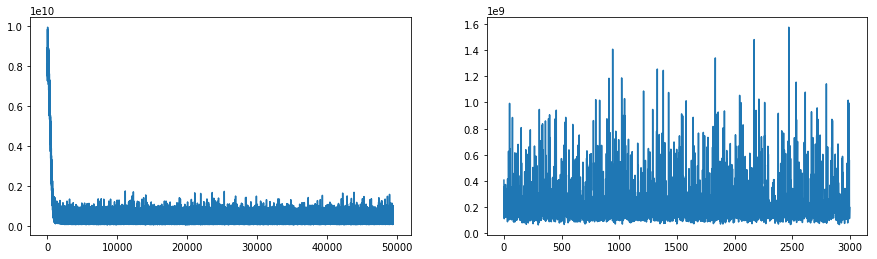

In [116]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(losses)
plt.subplot(122)
plt.plot(losses[-3000:])

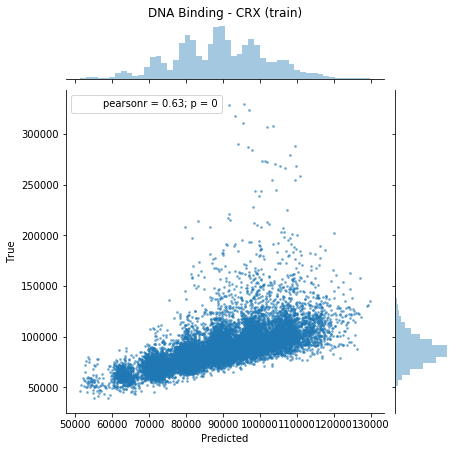

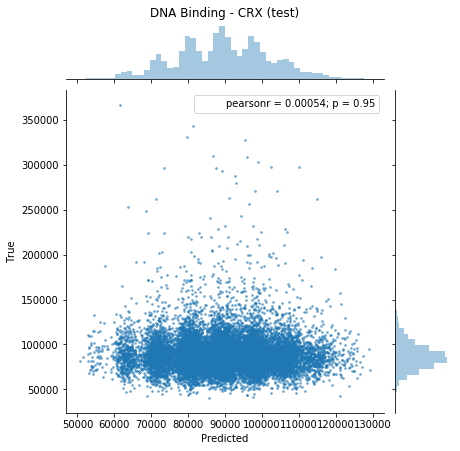

In [130]:
title = "DNA Binding - CRX"
train_title = title + " (train)"
test_title = title + " (test)"

jointplot(model(train_inputs).squeeze(), train_labels, train_title)
jointplot(predictions, test_labels, test_title)

## BNN

In [7]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, test_size=.5, random_state=521)
train_inputs = torch.tensor(train_inputs).float().to(device)
train_labels = torch.tensor(train_labels).float().to(device)
test_inputs = torch.tensor(test_inputs).float().to(device)
test_labels = torch.tensor(test_labels).float().to(device)

In [18]:
n_samples = 10
prior_mean = 0
prior_std = .05

priors = lambda: normal_priors(model, prior_mean, prior_std)
# priors = lambda: spike_slab_priors(model, std2=1.5)
variationals = lambda: normal_variationals(model, prior_mean, prior_std)
bnn_model = make_bnn_model(model, priors, batch_size=batch_size)
guide = make_guide(model, variationals)
# guide = AutoDiagonalNormal(model)

optimizer = pyro.optim.Adam({'lr': 0.01})
pyro.clear_param_store()
svi = pyro.infer.SVI(bnn_model, guide, optimizer, pyro.infer.Trace_ELBO(n_samples))

losses = []
train_corrs = []
test_corrs = []
best_train_corrs = []
best_test_corrs = []

In [19]:
for _ in range(200):
    losses += train(svi, 1000, train_inputs, train_labels, verbose=True)

    preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
    train_corrs.append(kendalltau(preds, train_labels)[0])

    preds = bnn_predict(guide, test_inputs, n_samples=50).mean(axis=0)
    test_corrs.append(kendalltau(preds, test_labels)[0])

    _, sorted_idx = train_labels.sort(descending=True)
    n_10_percent = int(len(train_labels) * .1)

    preds = bnn_predict(guide, train_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
    best_train_corrs.append(kendalltau(preds, train_labels[sorted_idx][:n_10_percent])[0])

    _, sorted_idx = test_labels.sort(descending=True)
    n_10_percent = int(len(test_labels) * .1)

    preds = bnn_predict(guide, test_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
    best_test_corrs.append(kendalltau(preds, test_labels[sorted_idx][:n_10_percent])[0])

[S0000] loss: 67,096,782,596,049
[S0000] loss: 3,512,594,886,895
[S0000] loss: 2,309,709,114,693
[S0000] loss: 1,281,534,447,314
[S0000] loss: 1,903,263,963,372
[S0000] loss: 2,242,508,404,904
[S0000] loss: 2,026,445,720,210
[S0000] loss: 1,308,157,189,639
[S0000] loss: 1,496,539,920,820
[S0000] loss: 1,684,330,066,063
[S0000] loss: 1,413,731,712,098
[S0000] loss: 1,434,695,821,799
[S0000] loss: 1,409,095,801,019
[S0000] loss: 1,339,414,751,582
[S0000] loss: 1,657,394,208,617
[S0000] loss: 1,552,715,669,135
[S0000] loss: 1,351,493,385,917
[S0000] loss: 930,018,778,209
[S0000] loss: 1,051,786,368,276
[S0000] loss: 1,212,620,762,044
[S0000] loss: 968,006,119,998
[S0000] loss: 1,197,196,064,851
[S0000] loss: 1,338,879,127,397
[S0000] loss: 1,067,756,791,882
[S0000] loss: 820,245,422,624
[S0000] loss: 990,446,086,605
[S0000] loss: 1,310,920,354,427
[S0000] loss: 2,006,074,636,486
[S0000] loss: 895,642,688,612
[S0000] loss: 1,138,391,254,517
[S0000] loss: 1,027,664,811,250
[S0000] loss: 772

In [20]:
train_corrs = np.array(train_corrs)
best_train_corrs = np.array(best_train_corrs)
test_corrs = np.array(test_corrs)
best_test_corrs = np.array(best_test_corrs)
losses = np.array(losses)

np.savez("corrs.npz",
         train_corrs=train_corrs,
         best_train_corrs=best_train_corrs,
         test_corrs=test_corrs,
         best_test_corrs=best_test_corrs,
         losses=losses)

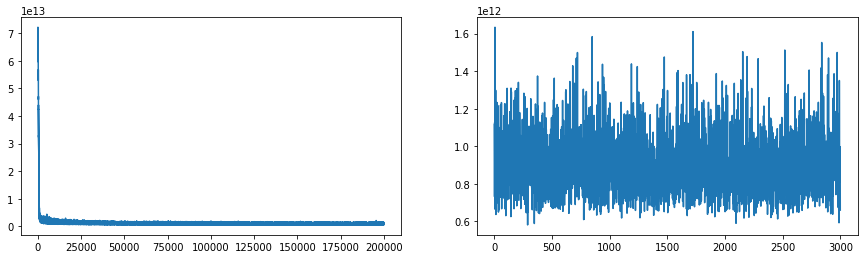

In [22]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
plt.plot(losses)
plt.subplot(122)
plt.plot(losses[-3000:])
# plt.plot(pd.Series(losses[-3000:]).rolling(window=100).median());

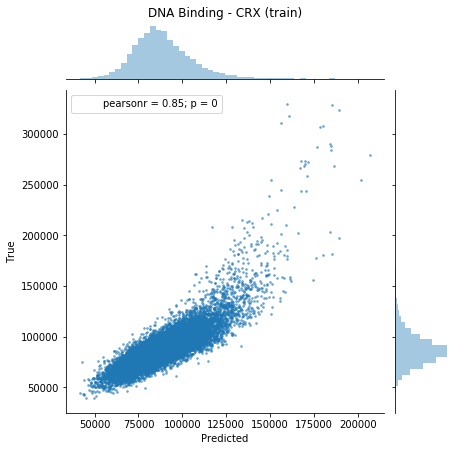

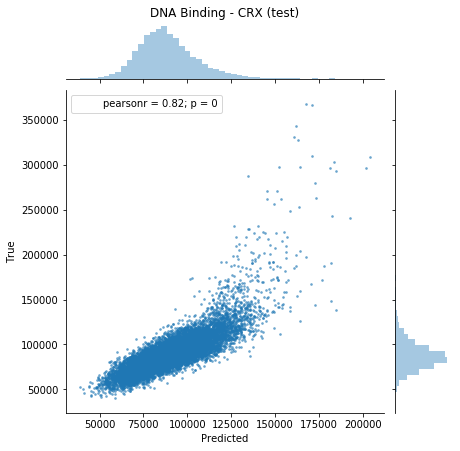

In [35]:
title = "DNA Binding - CRX"
train_title = title + " (train)"
test_title = title + " (test)"

preds = bnn_predict(guide, train_inputs, n_samples=50).mean(axis=0)
ax = jointplot(preds, train_labels, train_title)

preds = bnn_predict(guide, test_inputs, n_samples=50).mean(axis=0)
jointplot(preds, test_labels, test_title)

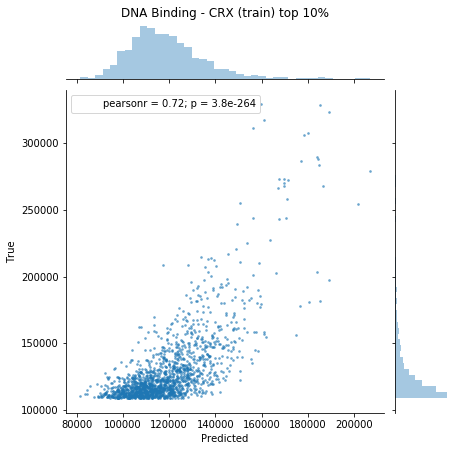

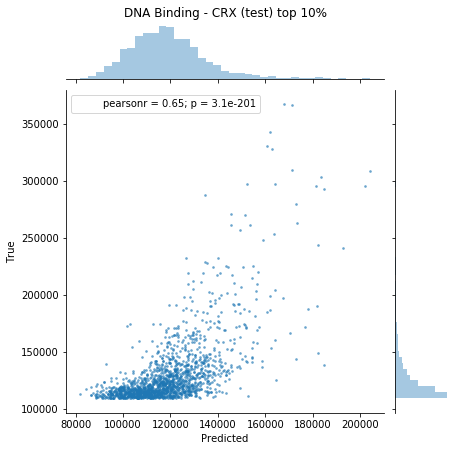

In [24]:
_, sorted_idx = train_labels.sort(descending=True)
n_10_percent = int(len(train_labels) * .1)

preds = bnn_predict(guide, train_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
jointplot(preds, train_labels[sorted_idx][:n_10_percent], train_title + " top 10%")

_, sorted_idx = test_labels.sort(descending=True)
n_10_percent = int(len(test_labels) * .1)

preds = bnn_predict(guide, test_inputs[sorted_idx][:n_10_percent], n_samples=50).mean(axis=0)
jointplot(preds, test_labels[sorted_idx][:n_10_percent], test_title + " top 10%")

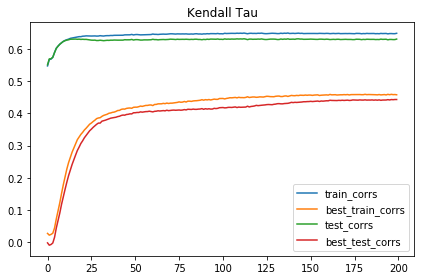

In [42]:
plt.plot(train_corrs, label="train_corrs")
plt.plot(best_train_corrs, label="best_train_corrs")
plt.plot(test_corrs, label="test_corrs")
plt.plot(best_test_corrs, label="best_test_corrs")
plt.legend()
plt.title("Kendall Tau")
plt.tight_layout()
plt.savefig("tmp.png", transparent=True)

In [27]:
test_corrs.max(), test_corrs[-1]

(0.6320830845088631, 0.6310942619113743)

In [31]:
test_corrs.argmax(), best_test_corrs.argmax()

(112, 198)

In [29]:
best_test_corrs.max(), best_test_corrs[-1], best_test_corrs[test_corrs.argmax()]

(0.44320747743671457, 0.4431846874849643, 0.41946856987540343)

* Count how often points show up in the distribution over the max input
* See whether the point you select (for batch size one) shows up (and how much, compared to the most)
* Incremental training
  * How many steps? Do some testing?
* UCB
* EI - this is BNN greedy, right?

* Why is HSIC worse than uniform sampling?

In [70]:
model_name = "crx_prediction"
pyro.get_param_store().save(f"{model_name}.params")
optimizer.save(f"{model_name}.opt")

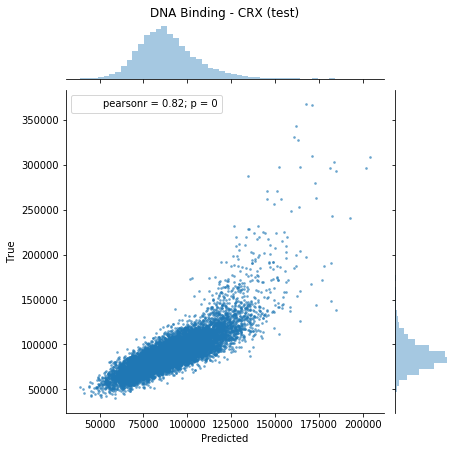

In [56]:
preds = bnn_predict(guide, test_inputs, n_samples=50).mean(axis=0)
jointplot(preds, test_labels, test_title)

In [57]:
pyro.clear_param_store()

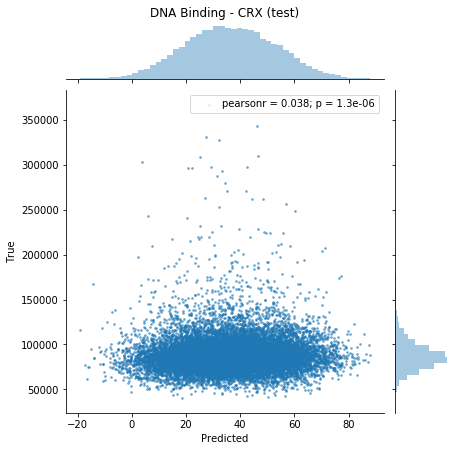

In [67]:
preds = bnn_predict(guide, test_inputs, n_samples=50).mean(axis=0)
jointplot(preds, test_labels, test_title)

In [76]:
pyro.clear_param_store()
pyro.get_param_store().load(f"{model_name}.params")
optimizer.load(f"{model_name}.opt")
# pyro.sync_module()

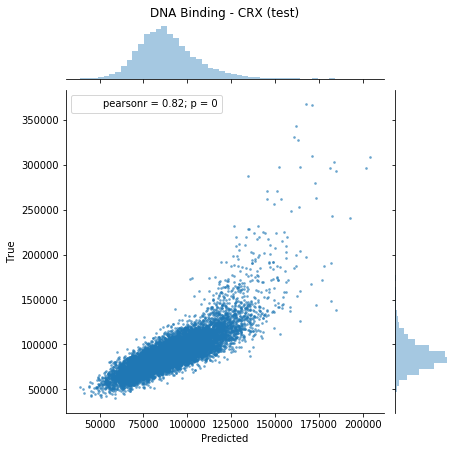

In [77]:
preds = bnn_predict(guide, test_inputs, n_samples=50).mean(axis=0)
jointplot(preds, test_labels, test_title)

# Some Plots

In [2]:
project_ids = api.get_project_names_and_ids("neighthan")
project_ids

{'bb-opt': 'b667ae9ddd1f42648260c89368afe1e4',
 'enrichment': 'bc3f0db9fd8c42e494eae720decb49d1',
 'evo': 'cf4ffd56df0c496ebbe6f9a1c55e6afa',
 'general': 'neighthan-NA'}

In [17]:
query_params = {'project': 'dna_binding'}
experiment_keys = api.get_experiments_with_params(project_ids["bb-opt"], query_params)

In [18]:
best_value = {}
for key in experiment_keys:
    params = api.get_params(key)
    metrics = api.get_metrics(key)
    
    name = params["save_key"]
    if name in best_value:
        best_value[name].append(metrics["best_value"].value.values)
    else:
        best_value[name] = [metrics["best_value"].value.values]

In [19]:
median = np.median(values, axis=0)
lower = np.percentile(values, 25, axis=0)
upper = np.percentile(values, 75, axis=0)

In [20]:
# handle mean and std as well as mean + explicit lower and upper error bounds
def plot_with_error(plot_data: Dict[str, Sequence[np.ndarray]]):
    for name, (mean, std) in plot_data.items():
        plt.plot(mean, label=name)
        plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.5)
    plt.legend()

In [21]:
bv = {}
for key, values in best_value.items():
    values = np.stack(values)[:, :30]
    print(key, len(values))
    bv[key] = (values.mean(0), values.std(0))

uniform 6
uniform 2x 6
nn 6
pdts 2
bnn 3
hsic 2


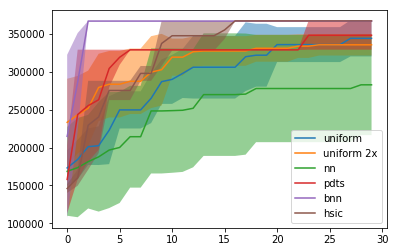

In [22]:
plot_with_error(bv)

In [23]:
best_value = {}
for key in experiment_keys:
    params = api.get_params(key)
    metrics = api.get_metrics(key)
    
    name = params["save_key"]
    if name in best_value:
        best_value[name].append(metrics["fraction_best"].value.values)
    else:
        best_value[name] = [metrics["fraction_best"].value.values]

In [24]:
bv = {}
for key, values in best_value.items():
    values = np.stack(values)
    print(key, len(values))
    bv[key] = (values.mean(0), values.std(0))

uniform 6
uniform 2x 6
nn 6
pdts 2
bnn 3
hsic 2


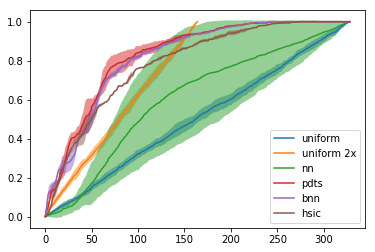

In [25]:
plot_with_error(bv)

* Set things to run only for 30-ish batches instead of the full 300?
  * That will make it fast for comparison w/ Tatsu, but it will mean we can't see the end of the fraction_best or similar metrics (though PDTS didn't show the end of it either)
* Draw samples PDTS-style, but maybe 10x as many, then subselect the batch based on HSIC
* Do MI-HSIC but only for a batch size of 1
* Do just mean/std without - lambda * HSIC ?